# testAPI_automate

Created by Davy Yue 2017-06-26

## Testing for Conversion into Function/Class ==============================

Code May Break At Anytime

In [1]:
## 2017_06_27 1:00 PM CST
## **** DEBUGGING/TESTING NOTES ****
## - think about inputs and outputs
## - think about where variables can be passed as parameters
## - need test cases - maybe with n-dodecane
## - need more filetypes to read instead of just hoomdxml
## - check with generated rdfs from testAPI_propane to compare results
## - maybe use more functions to call
## - consider adaptation for other elements (any periodic ones)
##       use element dictionary in msibi repo

### Imports

In [2]:
import itertools
import string
import os
import xml.etree.cElementTree as ET

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from msibi import MSIBI, State, Pair, mie
import mdtraj as md

## check possible other packages to ease process

### Functions

In [3]:
# TEST BOX
  # File Format:
  # type: string, "center element, number of surround elements,
  #       location in bead"
  #       - Element symbol corresponding with periodic-table abbreviation
  #       - E for ends of bead, M for middle
  # elements: string, elements in section of bead
  #       - Element symbol corresponding with periodic-table abbreviation
  #       - Element ordering follows same position in string as indices
  # map: dictionary, ordered indices of elements in bead section
  #       - Zero-indexing with separate incrementation for bead and 
  #         individual elements in the bead
  #       - Map will be extracted to expand for system


def read_user_mapping(user_mapping_filename):
    root = ET.parse(user_mapping_filename).getroot()
    
    bead = root.find('bead')
    molecule_name = bead.attrib["molecule_name"]
    print(molecule_name)
    
    n_sectionsPerUnit = 0 # number sections per unit being combined
    for section in bead.findall('section'):
         n_sectionsPerUnit += 1
     
    print(n_sectionsPerUnit)
    # check later for more different elements with loop
    
    return n_sectionsPerUnit, molecule_name    
# read_user_mapping(user_mapping_filename='propane_user_mapping.xml')

In [10]:
def read_system_info(struct_filename):
    root = ET.parse(struct_filename).getroot()
    n_sectionsTotal = int(root.find('configuration').find('position').attrib['num'])
    print(n_sectionsTotal) 
    
    return n_sectionsTotal
    
# read_system_info(struct_filename='start_aa.hoomdxml')

In [5]:
def create_system_mapping(element_names, n_units, t):
    # Initialize atoms with elements
    ## for loop to traverse element_names array for elements
    ## first test - only use for carbon (one element)
    ## then expand later
    ## need to allow for different types of elements together
    ## maybe use element library from msibi repo
    from mdtraj.core import element
    list(t.top.atoms)[0].element = element.carbon # check element
    list(t.top.atoms)[0].element.mass
    for atom in t.top.atoms:
        atom.element = element.carbon # check element
    
    # Map the beads accordingly
    cg_idx = 0
    start_idx = 0
    propane_map = {0: [0, 1, 2]} ## need better mapping definition
                                ## maybe integrate mapping with file read-in
                                ## flesh out in meeting (Tim, Justin, Alex)
    ## TEST CODE
    ######################################################################
    ######################################################################
    
    
    
    ######################################################################
    ######################################################################
    ## TEST CODE
    
            
    system_mapping = {}
    for n in range(n_units):
        for bead, atoms in propane_map.items():
            system_mapping[cg_idx] = [x + start_idx for x in atoms]
            start_idx += len(atoms) # understand this part of the function
            cg_idx += 1    
    
    # Apply mapping for XYZ coordinates
    cg_xyz = np.empty((t.n_frames, len(system_mapping), 3))
    for cg_bead, aa_indices in system_mapping.items():
        cg_xyz[:, cg_bead, :] = md.compute_center_of_mass(t.atom_slice(aa_indices))
        
    # Apply mapping for Topology object
    cg_top = md.Topology()
    for cg_bead in system_mapping.keys(): #i got the keys keys keys
        cg_top.add_atom('carbon', element.virtual_site, cg_top.add_residue('A', 
                            cg_top.add_chain())) 
        ## Check element and name for items 'A'
        ## Possible interface with mbuild for better UI and aesthetics
        
        
    return cg_xyz, cg_top

In [6]:
def compute_files(cg_xyz, cg_top, t, molecule_name):
    # Create Trajectory object and save to .dcd file 
    ## any file type might do - check with Tim
    ## maybe save to file type that is the same as inputted file-type
    cg_traj = md.Trajectory(cg_xyz, cg_top, time=None, 
                            unitcell_lengths=t.unitcell_lengths, 
                            unitcell_angles=t.unitcell_angles)
    ## need better file naming convention and rule guideline
    cg_traj.save_dcd('cg_traj_{0:s}.dcd'.format(element_names[0])) ## need check statements to prevent file overwrite
                                    ## rename old/new files accordingly

    # Create rdfs file from pairs
    ## might need for loop if more elements (later implementation)
    ## need some way to recognize pairs of units - not just carbon elements if expanded
    pairs = cg_traj.top.select_pairs(selection1='name {0:s}'.format(element_names[0]), ## Check element
                                     selection2='name {0:s}'.format(element_names[0])) ## Check element
    r, g_r = md.compute_rdf(cg_traj, pairs=pairs, 
                            r_range=(0, 1.2), bin_width=0.005) 
                    ## identify end of range with data pairs
                    ## maybe something with read-file function - compare data values next to each other
                    ## See where data drop-off occurs and plot respectively
                    ## maybe use slope - negative less than some number, set as cutoff
                    ## record cutoff point somewhere for debugging purposes
    np.savetxt('rdfs_aa.txt', np.transpose([r, g_r])) # need check statements to prevent file overwrite
    
    plot_output(r, g_r, molecule_name)

In [7]:
def plot_output(x, y, molecule_name):
    ## modify figsize according to drop-off point
    plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(x, y, label="CG {0:s}".format(molecule_name)) ## Check label use string format method
    
    ## look up more aesthetic matplotlib functions
    plt.xlabel("r")
    plt.ylabel("g(r)")
    plt.legend()

In [12]:
def convert_Traj_RDF():
    ## add parameters to function calls - maybe add other functions
    ## other potential functions:
    ##     - check_file_overwrite()
    ##     - check_g_r_dropoff() - integrate with plot function
    ##     - manage_filetypes() - read in files
    
    traj_filename = 'traj_unwrapped.dcd'
    struct_filename = 'start_aa.hoomdxml'
    user_mapping_filename = 'propane_user_mapping.xml'
    
    t = md.load(traj_filename, top=struct_filename)
    n_sectionsTotal = read_system_info(struct_filename)
    n_sectionsPerUnit, molecule_name = read_user_mapping(user_mapping_filename)
    n_units = n_sectionsTotal // n_sectionsPerUnit
    
    cg_xyz, cg_top = create_system_mapping(element_names, n_units, t)
    compute_files(cg_xyz, cg_top, t, molecule_name)

3072
Propane
3


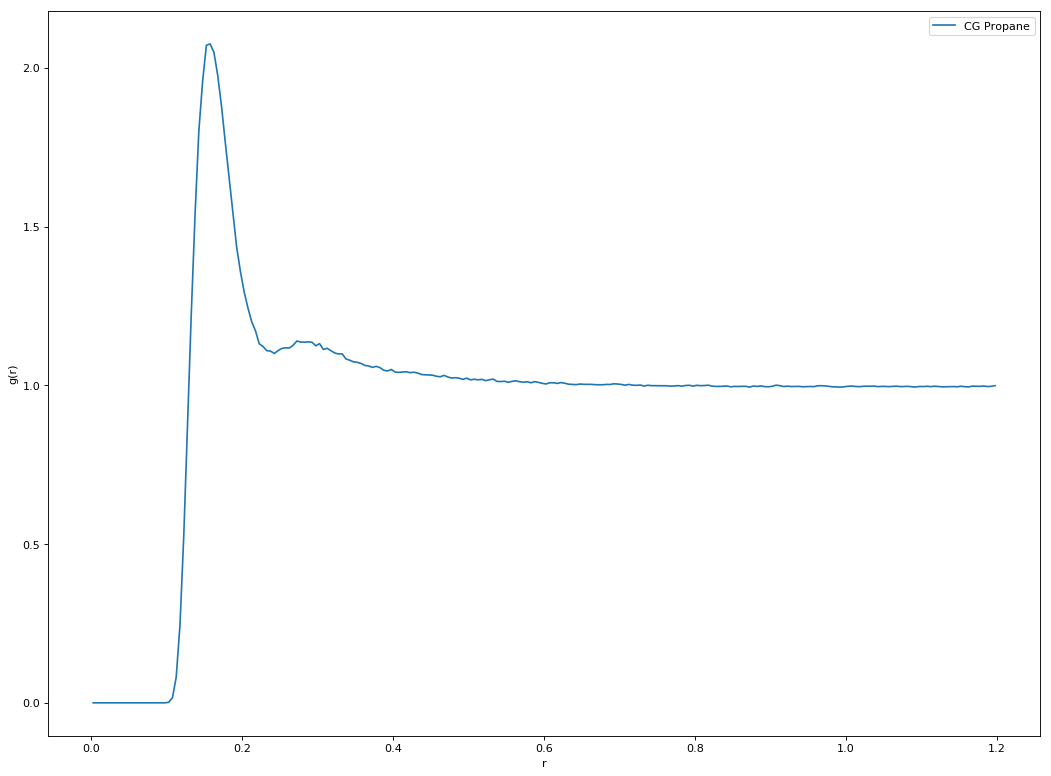

In [13]:
# Execute functions
## maybe use dictionary for element_names?
## incorporate the arguments in initialization for map_beads()
## maybe initialize element_names array from read-in file with bonds
## bonds recorded in structure indicate elements involved in rdf
element_names = ["carbon"]

convert_Traj_RDF()